# Real-Time fMRI Analysis

In typical fMRI experiments the researcher creates a sequence of stimuli or events they want to show in advance and then measures the participant's brain activity in response to this pre-specified task. This provides an assessment of the relationship between behavior in the task and BOLD activity. However, although tempting, it is not possible to conclude from this correlation alone that active brain regions are causing the behavior. Causal inferences typically require directly intervening to disrupt or enhance the functioning of a brain region (e.g., via stimulation, lesioning, cooling, etc.) and then examining the intervention's impact on behavior. Experimental manipulations of brain function, especially within specific regions, require invasive techniques and so are not possible in healthy humans for ethical reasons.

Real-time fMRI is a step in the direction of (safely) manipulating brain regions, enabling more valid causal inferences about the brain and behavior. Specifically, rather than brain activity being just a dependent variable, it becomes part of the experimental design as a kind of independent variable. For more on real-time fMRI, see [here](https://doi.org/10.1177/1073858411407205) or [here](https://www.nature.com/articles/nrn.2016.164).

Take, for instance, a study using real-time fMRI to train attention [deBettencourt et al. (2015)](http://ntblab.yale.edu/wp-content/uploads/2015/03/deBettencourt_NN_2015.pdf). In this study, patterns of brain activity were used to make the task easier or harder depending on the participant's attentional state, with the goal of training them to attend better. However, if the brain activity was too noisy or analyzed inappropriately, read out from brain regions that didn't contain information about attentional state, or taken from another participant's brain (as in the control condition), then the participant's attention should not improve.

There are no second chances with real-time fMRI because your analysis is part of data collection. For example, you can't later decide to use a different preprocessing step, analysis algorithm, parameter setting, feedback type, etc. This is why preparation, piloting, and efficient code is critical for real-time fMRI. Think of it as mandatory pre-registration!

There are many different types of real-time fMRI, but here we focus on using the multivariate methods from earlier notebooks to analyze data on the fly and generate feedback for participants in a closed-loop manner.


## Goal of this script
    1. Learn to design a multivariate real-time fMRI experiment  
    2. Run a real-time fMRI analysis using simulated data  


## Table of Contents
[1. The real-time workflow](#rt_wf)  
>[1.1. Data file preparation](#data_prep)  
>[1.2. File watcher](#file-watch)   
>[1.3. Preprocessing a volume](#preprocess-tr)  
>[1.4. Training a model](#real-time-train)  
>[1.5. Classifying new volumes](#real-time-test)  
>[1.6. Modifying stimuli for feedback](#mod-stim)  
  
[2. Running a real-time simulation](#real-time-sim)

[3. Adaptive real-time experiments](#real-time-change)


Exercises
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)    
>[Novel contribution](#novel)   

## 1. The real-time workflow <a id="rt_wf"></a>

The following sequence of steps are necessary for successfully running a real-time fMRI analysis. 

1. [Data file preparation](#data_prep): Setup a folder where fMRI volumes will be stored as they are created.
        
2. [File watcher](#file-watch): A function that looks for a volume to process.

3. [Preprocessing a volume](#preprocess): Preprocess the TR to prepare it for classification.

4. [Training a model](#real-time-train): Take the data you have set aside for training and create your classifier model.

4. [Classifying new volumes](#real-time-test): Take an epoch of data and classify that, assigning it a label.

6. [Modifying stimuli for feedback](#mod-stim): The classifier results influence the next stimulus shown to the participant.

Here is an example pipeline from deBettencourt et al. (2015):

![alt text](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnn.3940/MediaObjects/41593_2015_Article_BFnn3940_Fig1_HTML.jpg?as=webp)


In [1]:
import os
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import time
import numpy as np 
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn.linear_model import LogisticRegression  
from watchdog.events import PatternMatchingEventHandler 
from watchdog.observers import Observer 
from queue import Queue
from sklearn import svm
from sklearn import linear_model
import scipy.stats
from scipy import stats
from IPython import display
import shutil
from utils import results_path

### 1.1 Data file preparation <a id="data_prep"></a>

As you know, an fMRI data volume is generated for each TR. The scanner outputs these files one-by-one in DICOM format, and these files are then transferred via a network link from the scanner to the analysis computer (at Yale, our remote compute cluster). We will not cover here how to create a network link between your scanner and your analysis computer, but you can find example instructions for Siemens [here](https://www.fieldtriptoolbox.org/development/realtime/fmri/). Once these files are transferred to the analysis computer, the data from the DICOM images needs to be read into a numpy array. The code below will then process the numpy array. One way to read DICOM files into numpy is by using the package [dicom-numpy](http://dicom-numpy.readthedocs.io/en/latest/).

For this notebook, we will generate simulated data using the BrainIAK [fmrism module](http://brainiak.org/docs/brainiak.utils.html?highlight=fmrisim#module-brainiak.utils.fmrisim). The function *generate_data.py* simulates a two-condition experiment where each condition is blocked for 10s with no gap between events. This function simulates fMRI noise and then inserts signal in two regions corresponding to the two conditions with the appropriate hemodynamic response function. 

**Exercise 1:**<a id="ex1"></a> Investigate the `generate_data.py`. How does `generate_data.py` decide the presentation of the two conditions? Is this how you would design an fMRI study? If not, modify the script to what you think is a better design. <br> *Before modifying your code in `generate_data.py` please test it out in the notebook. Plot the stimuli as generated before and after your modification.*


**A:**
The random 50/50 choice of 0 and 1 to determine the stimulus can in certain cases lead to problems. The random nature of the condition presentation could also cause issues with one stimulus being presented significantly more times than the other on certain random instances. It would be preferable for each condition to occur the same amount of times as the other.

15
25


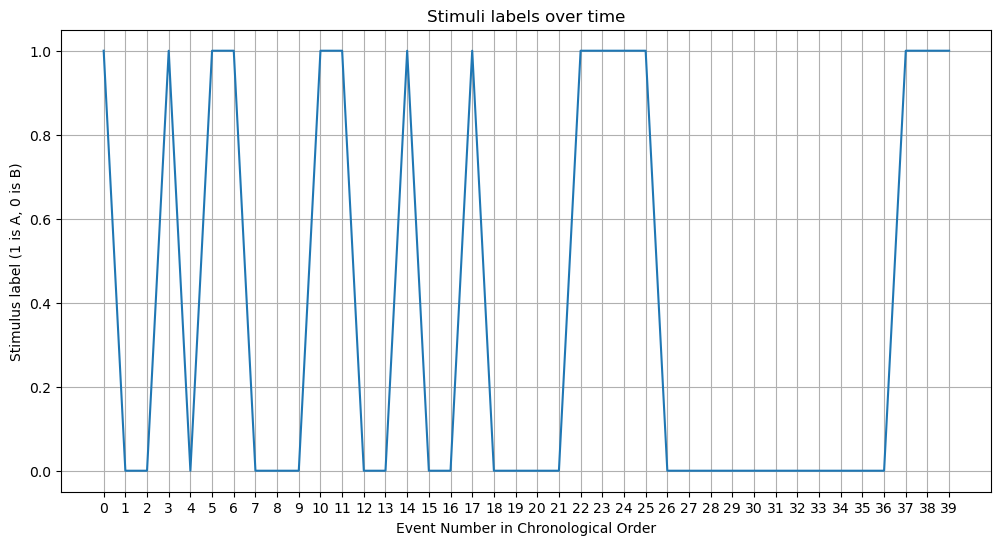

In [5]:
# Insert code here
# Generate a noise volume given a set of parameters

import os
import glob
import time
import random
import inspect
import typing
import nibabel  # type: ignore
import numpy as np  # type: ignore
from brainiak.utils import fmrisim as sim  # type: ignore
import sys
sys.path.append(os.getcwd())
import utils

# Specify the volume parameters
trDuration = 2  # seconds
numTRs = 200 # How many TRs will you generate?

# Set up stimulus event time course parameters
event_duration = 10  # How long is each event
isi = 0  # What is the time between each event
burn_in = 0  # How long before the first event

# Specify signal magnitude parameters
signal_change = 20 # How much change is there in intensity for the max of the patterns across participants
multivariate_pattern = 0  # Do you want the signal to be a z scored pattern across voxels (1) or a univariate increase (0)
switch_ROI = 0 # Do you want to switch the ROIs over part way through 

# Create the stimulus time course of the conditions
total_time = int(numTRs * trDuration)
events = int(total_time / event_duration)

onsets_A, onsets_B = [], []
# # Generate the onsets of each event
for event_counter in range(40):
    
    # Flip a coin for each epoch to determine whether it is A or B
    if np.random.randint(0, 2) == 1:
        onsets_A.append(event_counter * event_duration)
    else:
        onsets_B.append(event_counter * event_duration)
        
print(len(onsets_A))
print(len(onsets_B))

stimplot = []
j = 0
for i in range(40):
    if j < len(onsets_A) and onsets_A[j] == i*10:
        stimplot.append(1)
        j += 1

    else:
        stimplot.append(0)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the line graph
ax.plot(stimplot, label='Line 1')

# Add title and labels for the axes
ax.set_title('Stimuli labels over time')
ax.set_xlabel('Event Number in Chronological Order')
ax.set_ylabel('Stimulus label (1 is A, 0 is B)')
ax.set_xticks(range(40))


ax.grid(True)

# Display the plot
plt.show()

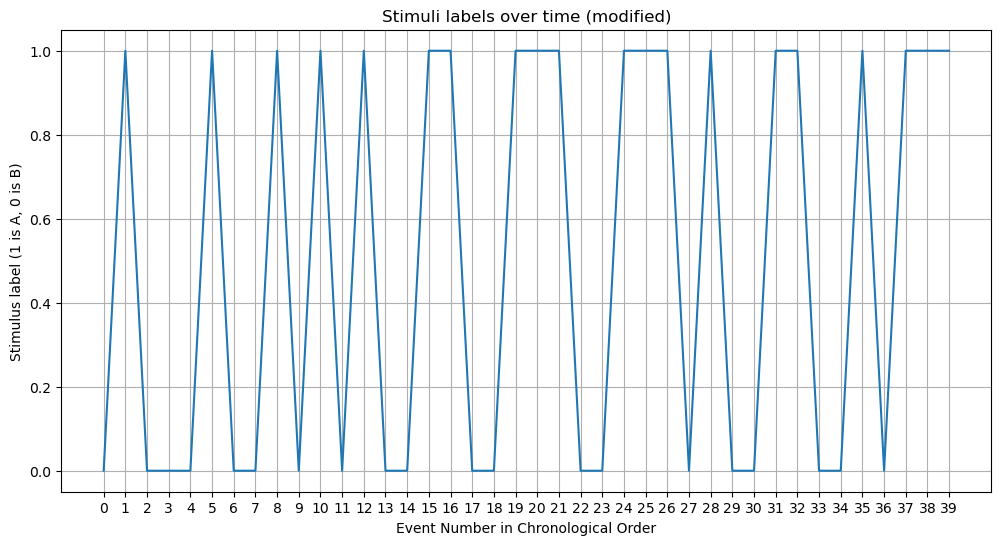

[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
20
20


In [6]:
import random
stimplot = []
# # Generate the onsets of each event
for i in range(20):
    stimplot.append(1)
for i in range(20):
    stimplot.append(0)
random.shuffle(stimplot)

onsets_A, onsets_B = [], []
for event_counter in range(len(stimplot)):
    
    # Flip a coin for each epoch to determine whether it is A or B
    if stimplot[event_counter] == 1:
        onsets_A.append(event_counter * event_duration)
    else:
        onsets_B.append(event_counter * event_duration)
        
        



fig, ax = plt.subplots(figsize=(12, 6))

# Plot the line graph
ax.plot(stimplot, label='Line 1')

# Add title and labels for the axes
ax.set_title('Stimuli labels over time (modified)')
ax.set_xlabel('Event Number in Chronological Order')
ax.set_ylabel('Stimulus label (1 is A, 0 is B)')
ax.set_xticks(range(40))


ax.grid(True)

# Display the plot
plt.show()

print(stimplot)        
print(len(onsets_A))
print(len(onsets_B))

here, both conditions display an equal number of times.

To simulate real-time data, this function outputs a TR every 2 s and saves it as a numpy array in the `~/palmer_scratch/brainiak_results/12-real-time/data/*` folder. To run the script, run the cell below. **Note: This script will take about 8 minutes to run**

In [6]:
# Run the generate_data script
if shutil.which('sbatch') is not None:
    !sbatch ./12-real-time/run_generate_data.sh
else:
    %run ./12-real-time/generate_data.py 

Submitted batch job 18579903


**Any time you want to simulate the acquisition of data, you should delete the contents of this folder** (`rm -rf ~/palmer_scratch/brainiak_results/12-real-time/data`) **and then run the generation again.**

In [7]:
 #!rm -rf ~/palmer_scratch/brainiak_results/12-real-time/data/

<div class="alert alert-block alert-info">
<strong> Reminder: Helpful SLURM hints.</strong>
<br>
When you submit a job on Milgram, SLURM prints out the job_ID (say, 12345679). You can check the status of all your running jobs with: `squeue --me`. You can check how a job completed and the statistics of its resource usage with `seff 12345679`. 
You can cancel a running job with `scancel 12345679`.   
</div>

Below we will set the paths to be used. We also want to specify the proportion of trials that will be used for training the model (time until the real-time neurofeedback kicks in).

In [8]:
input_dir = '12-real-time/fmrisim/' # Information on the simulated data.
data_dir = os.path.join(results_path, '12-real-time/data/')  # Simulated data path.
file_pattern = 'rt_{0:0>3}.npy'  # Filename pattern.
train_count = 40  # Training trials.

### 1.2 File watcher <a id="file-watch"></a>

For real-time fMRI, we need to monitor as every TR comes in. The simple way to do this is to just set up a loop that checks whether the file exists and waits until it does.

In [9]:
# Create a file watching algorithm where sleep_time is the temporal resolution
# of the file watcher
def tr_watcher_simple(filename, sleep_time=0.1):
    
    # While the file doesn't exist, loop and wait
    while not os.path.exists(filename):
        time.sleep(sleep_time)  # How long do you want to wait for
        
    # When the file exists, load it and output it
    vol = np.load(filename)
    
    return vol

use_simple_watcher = 1

However, this procedure is inefficient and prone to error. For instance, if a volume is added just after a check, this code waits the sleep time before checking again. Moreover, this procedure can crash since the file names often exist before the file contents are created.

Instead, to process volumes as soon as they are finished being created, a file watcher function continuously polls for new files. Once a new file is found, it is added to a queue and triggers a call to the next processing step. The [watchdog package](https://pythonhosted.org/watchdog/) is used for this purpose.

In [10]:
# Create a file watching algorithm that continuously polls.
def tr_watcher(filename, file_queue):
    # Does the file exist?
    file_exists = os.path.exists(filename)
    # While the file doesn't exist, loop and wait.
    while not file_exists:
        # Look for file creation event.
        event = file_queue.get()
        # If there is an event, save it
        if event.src_path == filename:
            file_exists = True    
    # When the file exists, load it and output it
    vol = np.load(filename)
    return vol


# Create a class of objects to handle new files.
class file_notify_handler(PatternMatchingEventHandler):

    # Initialize the object being created.
    def __init__(self, queue, file_pattern):
        super().__init__(patterns=file_pattern)
        self.q = queue
    
    # When an event occurs, put it in the queue.
    def on_created(self, event):
        self.q.put(event) 

We are going to check out this file watcher in action. Remember to clear your `12-real-time/fmrisim/data` directory and re-launch `run_generate_data.sh`. This script will first play catch up and then print every time a new TR comes in until the training set is acquired.<br>
*Note: We're going to use the simple watcher here, which works more reliably in Jupyter notebooks than the fancy watcher. You'd use the fancy one in a real experiment.*

In [11]:
use_simple_watcher = 1 # let's use the simple version.

# # Uncomment the next lines when you're ready to restart.
!rm -rf ~/palmer_scratch/brainiak_results/12-real-time/data/*
!sbatch ./12-real-time/run_generate_data.sh

Submitted batch job 18587450


In [12]:
# This could take a few minutes to run!
if use_simple_watcher == 1:

    for idx in range(train_count): 

        # Figure out the next filename.
        next_filename = data_dir +file_pattern.format(idx) 
        vol = tr_watcher_simple(next_filename)

        # When the file exists, load it and output it.
        print(f'Received: {next_filename}')

# This is how you would use the fancy one. 
else:
    file_observer = Observer() # Creates a new observer object.
    file_queue = Queue() # Creates a new file queue.
    # set up the notifications for when a new TR is created
    notify_file_pattern = '*.npy'  
    file_notify = file_notify_handler(file_queue, [notify_file_pattern])  
    file_observer.schedule(file_notify, data_dir, recursive=False)  
    file_observer.start()  
    for idx in range(train_count): 

        # What file name are you going to load
        next_filename = data_dir + file_pattern.format(idx) 
        vol = tr_watcher(next_filename, file_queue)

        # When the file exists, load it and output it
        print(f'Received: {next_filename}')

    file_observer.stop()

Received: /home/cmhn_ak2776/palmer_scratch/brainiak_results/12-real-time/data/rt_000.npy
Received: /home/cmhn_ak2776/palmer_scratch/brainiak_results/12-real-time/data/rt_001.npy
Received: /home/cmhn_ak2776/palmer_scratch/brainiak_results/12-real-time/data/rt_002.npy
Received: /home/cmhn_ak2776/palmer_scratch/brainiak_results/12-real-time/data/rt_003.npy
Received: /home/cmhn_ak2776/palmer_scratch/brainiak_results/12-real-time/data/rt_004.npy
Received: /home/cmhn_ak2776/palmer_scratch/brainiak_results/12-real-time/data/rt_005.npy
Received: /home/cmhn_ak2776/palmer_scratch/brainiak_results/12-real-time/data/rt_006.npy
Received: /home/cmhn_ak2776/palmer_scratch/brainiak_results/12-real-time/data/rt_007.npy
Received: /home/cmhn_ak2776/palmer_scratch/brainiak_results/12-real-time/data/rt_008.npy
Received: /home/cmhn_ak2776/palmer_scratch/brainiak_results/12-real-time/data/rt_009.npy
Received: /home/cmhn_ak2776/palmer_scratch/brainiak_results/12-real-time/data/rt_010.npy
Received: /home/cmhn_

### 1.3 Preprocessing a volume <a id="preprocess-tr"></a>

As each volume is received, you must preprocess the volume before analyzing it. Given the constraint of wanting to do this as close as possible to real-time, you will need to choose steps carefully and decide on the minimal set of steps that provide the most benefit. For example, motion correction, masking, and normalization might be sufficient. The simulator does not generate any motion artifacts so that step is unnecessary in this notebook. Masking is critical because we don't want to feed the model irrelevant features. Normalization in space (as we will do) is easy because each time point can be treated independently; however, normalizing across time is hard since each additional TR will change the mean and SD, and thus the z-values of all preceding TRs. This is a more general consequence of real-time, wherein you know the past but not the future. This also impacts temporal filtering, which must be done with "causal" filters. For this reason, procedures for normalizing and filtering over time are still being developed/refined.

**Self-study:** Look into normalizing voxels across time. Helpful information is found in [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). For temporal filtering, compare the [filtfilt](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.filtfilt.html) and [lfilter](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.lfilter.html) functions in scipy.

**Exercise 2:** <a id="ex2"></a>  Create a preprocessing function that takes a volume and a mask, masks the volume, z-scores the masked voxels in space, then returns a vector of preprocessed voxels. Include docstring commenting for your function. Then, test your function by running the second cell.

In [13]:
def preprocess_vol(vol, mask):
    """
    Preprocesses fMRI data by applying a brain mask, z-scoring masked voxels in space,
    and returning a vector of preprocessed voxels.

    Parameters:
    vol (numpy.ndarray): 3D numpy array representing the brain volume.
    mask (numpy.ndarray): 3D numpy array representing the brain mask. The shape of the mask
                          should be the same as the shape of the brain volume.

    Returns:
    preprocessed_voxels (numpy.ndarray): 1D numpy array of preprocessed voxels.
    """
    # Z-score the masked voxels in space
    masked_voxels = vol[mask > 0]
    z_scored_voxels = stats.zscore(masked_voxels)

    # Return the preprocessed voxels as a vector
    preprocessed_voxels = np.ravel(z_scored_voxels)

    return preprocessed_voxels

In [14]:
# Test your code. 
# Load one of your simulated files.
test_volume = np.load(data_dir+'/rt_000.npy')
# Load a mask.
test_mask = nib.load('./12-real-time/fmrisim/ROI_A.nii.gz').get_fdata()
# Run your function.
preprocessed_volume = preprocess_vol(test_volume, test_mask)
print(preprocessed_volume.shape, preprocessed_volume.mean(), preprocessed_volume.std())

(442,) 2.2439396e-07 1.0


In [15]:
preprocessed_volume.shape

(442,)

**Exercise 3:** <a id="ex3"></a> Do a speed test of the file watcher and preprocessing functions to make sure they complete in less than 1 TR (here, 2s). Specifically, add to the starter code below appropriate time stamping and print commands. 

**Reminder: You will need to re-run the `run_generate_data.sh` script to do a proper timing test, and should delete the contents of the data directory as well as cancel any already running scripts before running a new real-time simulation. You will want to separate some of the code into different cells so that you do not necessarily restart the generation script every time you rerun your code.** 

In [16]:
# # TO DO: Delete contents of data directory
!rm -rf ~/palmer_scratch/brainiak_results/12-real-time/data/*

# # TO DO: Restart the data simulation.
!sbatch ./12-real-time/run_generate_data.sh


Submitted batch job 18587464


In [19]:
mask.shape

NameError: name 'mask' is not defined

In [20]:
while not os.path.exists(data_dir +'mask.npy'):
    time.sleep(0.01) # WITH A TAB BEFORE time! 
mask_file = data_dir +'mask.npy'
mask = np.load(mask_file)

# TO DO: Pre-allocate a 2D array to hold the TR data of the following shape:
# [train_count, n_voxels_in_mask]
tr_data = [[0 for i in range(40)] for j in range(442)]
                   
# Cycle through TRs
for idx in range(train_count): 
    
    # TO DO: Start the timer
    t0 = time.time()
    
    # What file name are you going to load
    next_filename = data_dir + file_pattern.format(idx) 
    vol = tr_watcher_simple(next_filename)
    
    # TO DO: preprocess the volume and store it in tr_data at the appropriate location.
    tr_data[idx] = preprocess_vol(vol, mask)
    
    # TO DO: End the timer.
    t1 = time.time()
    # TO DO: Print the timing.
    print(t1 - t0)

9.246504306793213
2.1083273887634277
2.0095036029815674
2.106680393218994
2.12310528755188
2.1058900356292725
2.004746675491333
2.09926700592041
2.1059823036193848
2.0073671340942383
2.1114096641540527
2.106793165206909
2.052854537963867
2.1061344146728516
2.0068466663360596
2.105811834335327
2.0746593475341797
2.1179726123809814
2.1046998500823975
2.039788246154785
2.0084660053253174
2.2824273109436035
2.119647979736328
2.1063265800476074
2.005638837814331
2.0138003826141357
2.0872385501861572
2.1051571369171143
2.0045692920684814
2.0350584983825684
2.1503548622131348
2.104785203933716
2.104858160018921
2.006345748901367
2.0948545932769775
2.127383232116699
2.1049888134002686
2.0068893432617188
2.1045212745666504
2.013235092163086


### 1.4 Training a model  <a id="real-time-train"></a>

After we have collected enough volumes, we can then train our classifier. Like [deBettencourt et al. (2015)](http://ntblab.yale.edu/wp-content/uploads/2015/03/deBettencourt_NN_2015.pdf) we will use an L2 regularized logistic regression. Below a function is created to take in time by voxel training data and a list of labels for each volume and then fit a regression function to it.

In [23]:
# Train 2 Logistic Regression models
def train_logistic(training_data,
                   training_labels,
                   parameters='l2'):
    
    # Train the model predicting state 2 (so that true means 1 and false means 0)
    clf = LogisticRegression(penalty=parameters)
    clf.fit(training_data, training_labels == 2)

    return clf

A critical step when training the model is shifting the labels. We expect that a stimulus will evoke activity 4-6 s after its onset because of the hemodynamic lag.

In [24]:
# Load the labels
label_file = data_dir + 'labels.npy'
labels = np.load(label_file)

# How much do you need to shift the labels by in terms of TRs
tr_shift = 3

training_data   = tr_data[tr_shift:train_count]
training_labels = labels[:train_count - tr_shift].squeeze()

In [25]:
# Fit the model
clf = train_logistic(training_data, training_labels)

We can now visualize this training in order to see what the model has learned.

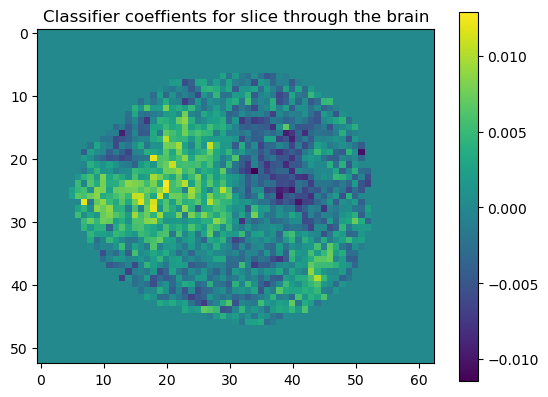

In [26]:
coefs = np.zeros(mask.shape)
coefs[mask==1]=clf.coef_[0,:]

f, ax = plt.subplots()
im=ax.imshow(coefs[:,:,30])
ax.set_title('Classifier coeffients for slice through the brain')
f.colorbar(im,ax=ax)

### 1.5 Classifying new volumes  <a id="real-time-test"></a>

Now that we have trained a model, we can classify incoming volumes with the learned weights. Since most classifiers come with the *.fit* and *.predict* formulation in scikit-learn, this is very easy to do (after some reshaping). In the case of a logistic regression, the outcome is binary (simply `True` or `False`). In this case, `True` means condition 2 and `False` means condition 1.

In [28]:
# Get a new volume.

# What file name are you going to load?
next_filename = data_dir + file_pattern.format(idx) 
vol = tr_watcher_simple(next_filename)    


# Store the volume as a preprocessed vector
new_data = preprocess_vol(vol, mask)
prediction = clf.predict(new_data.reshape(1, -1))

print(f'Prediction for TR {train_count+1} is condition {int(prediction+1)} and the label is {labels[idx - tr_shift]}')

Prediction for TR 41 is condition 1 and the label is [1.]


### 1.6 Modifying stimuli for feedback  <a id="mod-stim"></a>

The final step of closed-loop multivariate real-time fMRI is to use the classifier results and provide feedback to the participant in the scanner. This could involve changing the composition of the stimulus, changing the task difficulty, or providing feedback directly via a scale or gauge. Although we won't do this here, such displays can be easily implemented in experiment code from [Psychtoolbox](http://psychtoolbox.org/) or [PsychoPy](http://www.psychopy.org/).

## 2. Running a real-time simulation  <a id="real-time-sim"></a>

Now that we have all parts of the real-time workflow, we can put them together to run a simulated real-time experiment. The function below named `realtime` does this. 

This takes as an input the `fmrisim` directory. It also takes the number of volumes that are used for training and a function that specifies how to run the classifier (e.g., `train_logistic`). The final input `incremental_batch` will be discussed later.

In [29]:
def realtime(data_dir, train_count, clf_obj=train_logistic, incremental_batch=0, verbose=0, numTRs=200, display_figure=1): 
        
    # While the file doesn't exist, loop and wait.
    label_file = data_dir + 'labels.npy'
    while not os.path.exists(label_file):
        time.sleep(0.1)  # How long do you want to wait for
    
    # Load labels.
    labels = np.load(label_file)

    # Number of TRs to shift.
    tr_shift = 3
    
    # Load the mask.
    mask_file = data_dir +'mask.npy'
    mask = np.load(mask_file)

    #Pre-allocate a 2D array to hold the TR data.
    tr_data = np.full((numTRs, np.sum(mask)), np.nan)

    if display_figure == 1:
        # Set up the figure
        f, ax =plt.subplots() # Set up figure
        ax.plot((train_count, train_count), (0, 3), 'g')
        ax.set_xlim((0, len(labels)))
        ax.set_ylim((0, 3))
        ax.set_title('Searching for the first TR')
        is_print=0
    

    # Listen for TRs.
    num_correct = 0  # Preset the number of correct answers to zero.
    for idx in range(len(labels)): 

        # Filename to load.
        next_filename = data_dir + file_pattern.format(idx, '02d')  
        
        # Load the volume.
        
        vol = tr_watcher_simple(next_filename)
    
        # Store the volume.
        tr_data[idx, :] = preprocess_vol(vol, mask)
        
        # Display this figure.
        if display_figure == 1:
            ax.plot(range(idx), labels[:idx], 'r-')

        # Collect TRs for training
        if idx < train_count:
            if display_figure == 1:
                ax.set_title(f'TR: {idx} for training')
        elif idx == train_count: # If we have enough to train...
            # Train the classifier
            trainStart = time.time()
            
            if display_figure == 1:
                ax.set_title("Sufficient TRs collected, training the model")

            # Train the classifier
            clf = clf_obj(tr_data[tr_shift:train_count, :], labels[:train_count - tr_shift])
            
            if verbose:
                # Report the training duration
                print(f"Completed training in {np.round((time.time() - trainStart),2)} sec.")

        elif idx > train_count: # If it's testing ....

            # Pull out the predictions of the model for this TR
            prediction = clf.predict(tr_data[idx, :].reshape(1, -1))

            # If it is a boolean (0 or 1) then add 1 to turn it into the labels
            if prediction.dtype=='bool':
                prediction = prediction + 1

            if prediction == labels[idx - tr_shift]:
                num_correct += 1
            
            accuracy = num_correct / (idx - train_count)
            
            if display_figure == 1:
                ax.scatter(idx, prediction)
                ax.set_title(f'TR: {idx+1}; Total accuracy: {np.round(accuracy,2)}')

            # Do you want to create a new batch for training if doing an incremental fit
            if incremental_batch > 0 and np.mod((idx - train_count), incremental_batch) == 0:

                # Get the start of the batch
                start_idx = idx - incremental_batch

                # Feed in the classifier to be updated with the current batch size
                clf = clf_obj(tr_data[start_idx + tr_shift:idx, :], labels[start_idx:idx - tr_shift], clf)
                
                if display_figure == 1:
                    # Mark where the new batch was loaded in
                    ax.plot((idx, idx), (0, 3), 'k')
        
        if display_figure == 1:
            # Plot the figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            ax.set_xlim((0, len(labels)))
            ax.set_ylim((0, 3))
    
    # Return the accuracy overall
    return accuracy

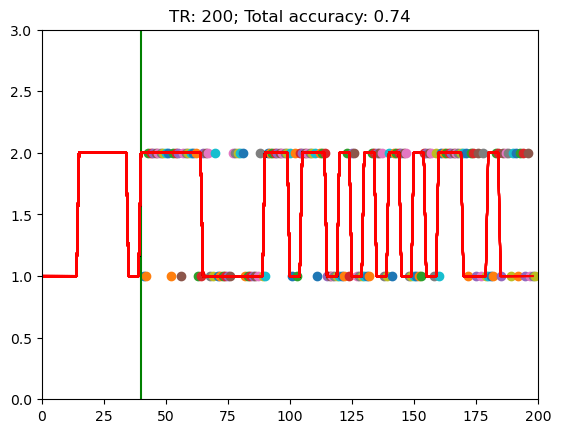

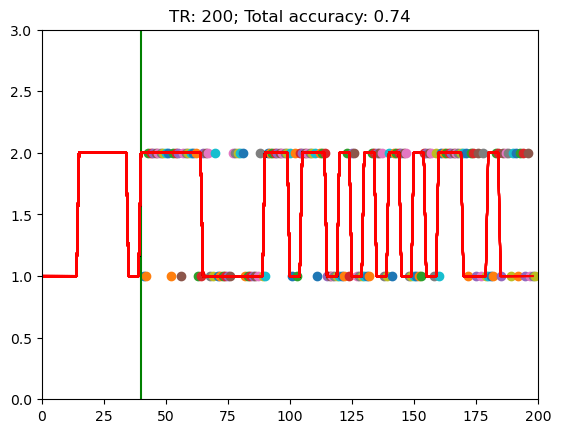

In [30]:
try:
    realtime(data_dir=data_dir,
             train_count=train_count,
             clf_obj=train_logistic,
             incremental_batch=0,
             verbose=1
            )
except Exception as err:
    print("Exception: {}".format(err))

**Exercise 4:**<a id="ex4"></a> Re-run the `realtime` function using a different classifier. Create a new classifier function with a different kernel and run it below.

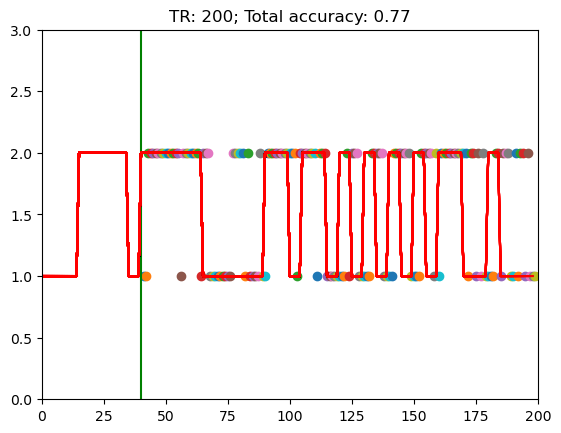

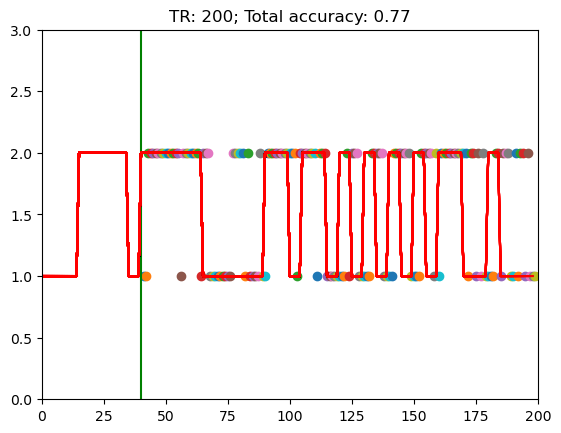

In [35]:
# Create a new classifier function
from sklearn.svm import LinearSVC

def train_linear_svm(training_data,
                     training_labels):
    
    # Train the model predicting state 2 (so that true means 1 and false means 0)
    clf = svm.SVC(kernel='linear')
    clf.fit(training_data, training_labels == 2)

    return clf
# Call it with the real-time function
try:
    realtime(data_dir=data_dir,
             train_count=train_count,
             clf_obj=train_linear_svm,
             incremental_batch=0,
             verbose=1
            )
except Exception as err:
    print("Exception: {}".format(err))
# Run the realtime function with this new classifier object.


**Exercise 5:**<a id="ex5"></a> Create a new function called `realtime_evidence` that follows the same logic as the `realtime` function but plots the classifier decision evidence rather than the labels. Make sure that you have an appropriate classifier that outputs the decision evidence for each prediction (and re-scale your figure appropriately). Run this function with the simulated data. *Hint: check out the `decision_function` method of different classifier objects.*

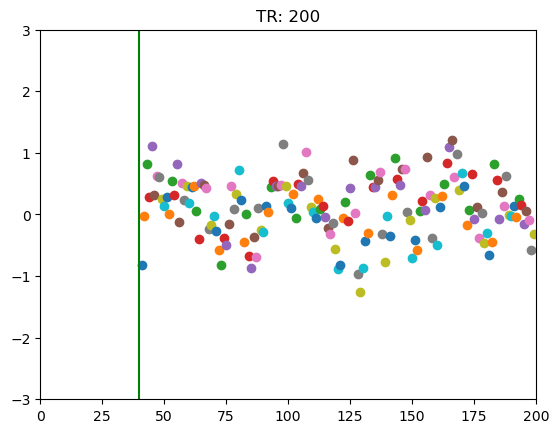

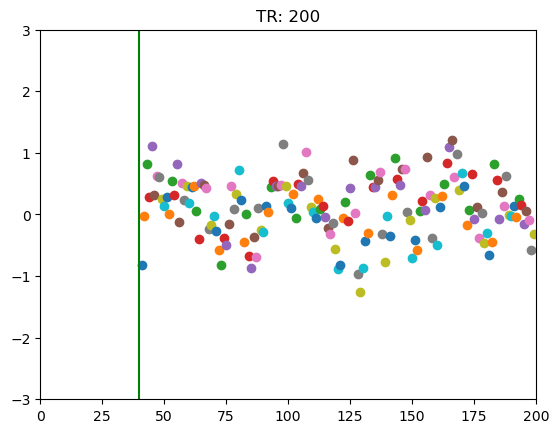

In [36]:
# Insert code here
def realtime_evidence(data_dir, train_count, clf_obj=train_logistic, incremental_batch=0, verbose=0, numTRs=200, display_figure=1): 
        
    # While the file doesn't exist, loop and wait.
    label_file = data_dir + 'labels.npy'
    while not os.path.exists(label_file):
        time.sleep(0.1)  # How long do you want to wait for
    
    # Load labels.
    labels = np.load(label_file)

    # Number of TRs to shift.
    tr_shift = 3
    
    # Load the mask.
    mask_file = data_dir +'mask.npy'
    mask = np.load(mask_file)

    #Pre-allocate a 2D array to hold the TR data.
    tr_data = np.full((numTRs, np.sum(mask)), np.nan)

    if display_figure == 1:
        # Set up the figure
        f, ax =plt.subplots() # Set up figure
        ax.plot((train_count, train_count), (-3, 3), 'g')
        ax.set_xlim((0, len(labels)))
        ax.set_ylim((0, 3))
        ax.set_title('Searching for the first TR')
        is_print=0
    

    # Listen for TRs.
    num_correct = 0  # Preset the number of correct answers to zero.
    for idx in range(len(labels)): 

        # Filename to load.
        next_filename = data_dir + file_pattern.format(idx, '02d')  
        
        # Load the volume.
        
        vol = tr_watcher_simple(next_filename)
    
        # Store the volume.
        tr_data[idx, :] = preprocess_vol(vol, mask)
        
        # Display this figure.
        # if display_figure == 1:
        #     ax.plot(range(idx), labels[:idx], 'r-')

        # Collect TRs for training
        if idx < train_count:
            if display_figure == 1:
                ax.set_title(f'TR: {idx} for training')
        elif idx == train_count: # If we have enough to train...
            # Train the classifier
            trainStart = time.time()
            
            if display_figure == 1:
                ax.set_title("Sufficient TRs collected, training the model")

            # Train the classifier
            clf = clf_obj(tr_data[tr_shift:train_count, :], labels[:train_count - tr_shift])
            
            if verbose:
                # Report the training duration
                print(f"Completed training in {np.round((time.time() - trainStart),2)} sec.")

        elif idx > train_count: # If it's testing ....

            # Pull out the predictions of the model for this TR
            prediction = clf.predict(tr_data[idx, :].reshape(1, -1))

            # If it is a boolean (0 or 1) then add 1 to turn it into the labels
            if prediction.dtype=='bool':
                prediction = prediction + 1

            if prediction == labels[idx - tr_shift]:
                num_correct += 1
            
            accuracy = num_correct / (idx - train_count)
            
            if display_figure == 1:
                ax.scatter(idx, clf.decision_function(tr_data[idx,:].reshape(1,-1)))
                ax.set_title(f'TR: {idx+1}')

            # Do you want to create a new batch for training if doing an incremental fit
            if incremental_batch > 0 and np.mod((idx - train_count), incremental_batch) == 0:

                # Get the start of the batch
                start_idx = idx - incremental_batch

                # Feed in the classifier to be updated with the current batch size
                clf = clf_obj(tr_data[start_idx + tr_shift:idx, :], labels[start_idx:idx - tr_shift], clf)
                
                if display_figure == 1:
                    # Mark where the new batch was loaded in
                    ax.plot((idx, idx), (0, 3), 'k')
        
        if display_figure == 1:
            # Plot the figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            ax.set_xlim((0, len(labels)))
            ax.set_ylim((-3, 3))
    
    # Return the accuracy overall
    return accuracy

try:
    realtime_evidence(data_dir=data_dir,
             train_count=train_count,
             clf_obj=train_linear_svm,
             incremental_batch=0,
             verbose=1
            )
except Exception as err:
    print("Exception: {}".format(err))

## 3. Adaptive real-time experiments  <a id="real-time-change"></a>

The goal of real-time fMRI is often to change brain function via neurofeedback. For instance, neural representations might change because the experiment trains participants to use different parts of their brain to process a stimulus. In such cases, a classifier trained at the start of the experiment will be wrong by the end of the experiment because the underlying feature space across voxels in the brain has changed. There are algorithms that can be used in these cases, which allow the model fit to be updated incrementally as new training examples come in. This can also be used to refine your model with more training data even if the underlying features are stable. 

This approach to dynamically training classifiers is called incremental or online learning and [scikit-learn](https://scikit-learn.org/0.15/modules/scaling_strategies.html) has a number of classifiers that allow this. Below we specify one classifier with this functionality. First we will run it without incremental updating as a baseline. 

Beware: The initialization of these functions can have a dramatic effect on performance, which you can evaluate by using a random seed.

In [37]:
def train_incremental(training_data, training_labels, parameters=None):
    
    all_classes = np.array([1, 2])  # Need to say all the labels, in case you want to test out of sample
    
    # Get the clf
    if not parameters:
        # Create the linear if it hasn't already been passed in by parameters
        clf = linear_model.SGDClassifier()
    else:
        clf = parameters  # Pull out the classifier
        
    # Fit the training data (either initializing the clf or updating it)    
    clf.partial_fit(training_data, training_labels, classes=all_classes)
    
    return clf

Now that we have run the classifier with static weights, we can try dynamically updating the classifier as we acquire more data. This is accomplished by telling `realtime` how often you want to update (here, after every additional 20 TRs). The `incremental_batch` variable specifies how many volumes are used in each batch of training.

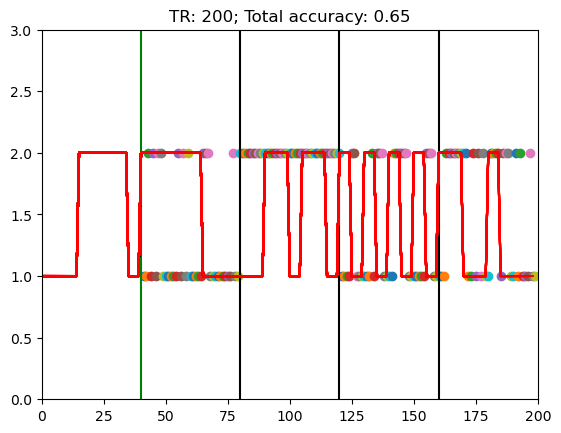

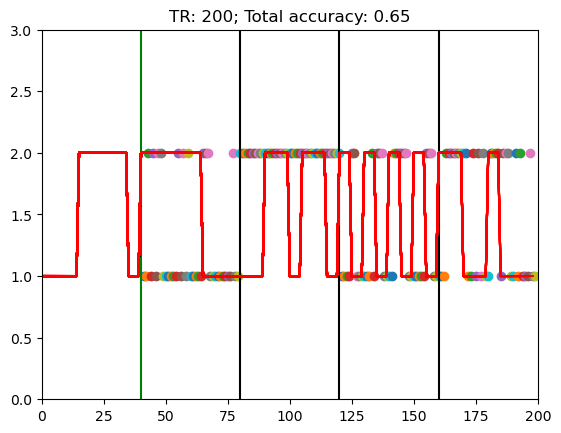

In [38]:
try:
    np.random.seed(0)
    realtime(data_dir=data_dir,
            train_count=train_count,
            clf_obj=train_incremental,
            incremental_batch=40,
            verbose=1
            )
except Exception as err:
    print("Exception: {}".format(err))

**Exercise 6:**<a id="ex6"></a> Re-train the model using the `realtime` function with batch sizes `[5, 10, 20, 40, 50, 100]`. Set `np.random.seed(0)` in your for-loop. Plot model accuracy as a function of batch size, making sure to label your plot and axes. What are the advantages of using a small vs. large batch? What appears to be the optimal batch size? 

*Note: You do not need to display the figure generated by `realtime` for this question! Turn off the `display_figure` parameter.*

**A:**  
Small batch sizes allow for faster training due to less volumes to process per batch while large batch sizes tend to lend themselves to higher accuracies as the classifier will have more volumes to train itself per batch. However, large batch sizes could lead to introduction of extra noise and overfitting,

Completed training in 0.01 sec.
Completed training in 0.01 sec.
Completed training in 0.01 sec.
Completed training in 0.01 sec.
Completed training in 0.01 sec.
Completed training in 0.01 sec.


Text(0, 0.5, 'accuracy')

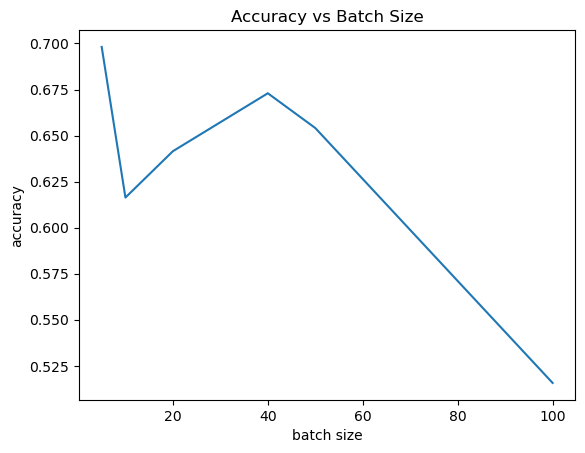

In [39]:
# Insert code here

try:
    batch_size_list = [5, 10, 20, 40, 50, 100]

    acclist = []
    np.random.seed(0)
    for batch_size in batch_size_list:


        accuracy = realtime(data_dir=data_dir,
                train_count=train_count,
                clf_obj=train_incremental,
                incremental_batch=batch_size,
                verbose=1,
                display_figure = 0            
                )
        acclist.append(accuracy)
    
except Exception as err:
    print("Exception: {}".format(err))
    
x = batch_size_list
y = acclist
plt.plot(x,y)
plt.title('Accuracy vs Batch Size')
plt.xlabel('batch size')
plt.ylabel('accuracy')

Here we see that the batch size of 5 has the highest accuracy, followed by a size of 40. This could be due to the coincidental nature of this particular data and the aforementioned overfitting and noise that is picked up at higher batch sizes. excluding the size of 5, we do see that between 10 and 40 batch size, there is a constant improvement in accuracy consistent with the prediction and a subsequent fall in accuracy as the large batch sizes introduce significant noise.

Now that we have a classifier that can update its weights dynamically, we will perform a simulation in which the responses in the fMRI data change part way through the study. The `generate_data.py` script is set up to allow for this.

**Exercise 7:**<a id="ex7"></a> Simulate new data where the brain areas that discriminate between conditions switch halfway through the run. Then, run real-time analyses on this new dataset using 3 training procedures: `train_incremental` using the optimal batch size identified above, our original `train_logistic`, and whichever kernel you chose to use in [Exercise 4](#ex4). Again, you do not need to display the graph from `realtime` -- just display the accuracies of these 3 models on a **labeled** bar graph. 

In [45]:
# Insert code here

#changed switchroi to 0.5

!rm -rf ~/palmer_scratch/brainiak_results/12-real-time/data/*


# Run the generate_data script
if shutil.which('sbatch') is not None:
    !sbatch ./12-real-time/run_generate_data.sh
else:
    %run ./12-real-time/generate_data.py 

Submitted batch job 18587844


Completed training in 0.01 sec.
Completed training in 0.6 sec.
Completed training in 0.03 sec.
the accuracies for incremental, logistic, and svm are: (0.5471698113207547, 0.4968553459119497, 0.5031446540880503) respectively


(0.35, 0.75)

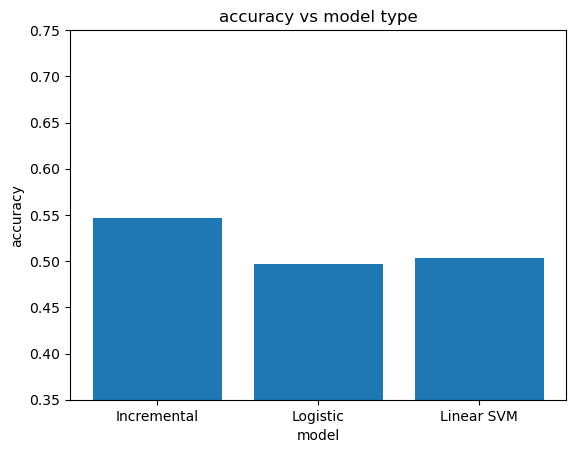

In [49]:
np.random.seed(0)
incrementalAccuracy = realtime(data_dir=data_dir,
                      train_count=train_count,
                      clf_obj=train_incremental,
                      incremental_batch=40,
                      verbose=1,
                      display_figure = 0            
                      )

logAccuracy = realtime(data_dir=data_dir,
              train_count=train_count,
              clf_obj=train_logistic,
              incremental_batch=0,
              verbose=1,
              display_figure = 0
              )

svmAccuracy = realtime(data_dir=data_dir,
              train_count=train_count,
              clf_obj=train_linear_svm,
              incremental_batch=0,
              verbose=1,
              display_figure = 0
              )

print(f'the accuracies for incremental, logistic, and svm are: {incrementalAccuracy, logAccuracy, svmAccuracy} respectively')

x = ['Incremental','Logistic','Linear SVM']
y = [incrementalAccuracy, logAccuracy, svmAccuracy]

plt.bar(x,y)
plt.title('accuracy vs model type')
plt.xlabel('model')
plt.ylabel('accuracy')
plt.ylim([0.35, 0.75])

Take this idea to the next level by doing a parameter search over different combinations of parameters

In [142]:
batch_values = range(10, 100, 10)
train_values = range(10, 100, 10)
results = np.zeros((len(batch_values), len(train_values)))
for batch_counter in range(len(batch_values)):
    for train_counter in range(len(train_values)):
        
        # Pull out the values
        batch_size = batch_values[batch_counter]
        train_size = train_values[train_counter]
        
        np.random.seed(0)
        print('batch size = %d, train size = %d' % (batch_size, train_size))
        result = realtime(data_dir=data_dir,
                          train_count=train_size,
                          clf_obj=train_incremental,
                          incremental_batch=batch_size,
                          display_figure=0
                         )

        # Store the results
        results[batch_counter, train_counter] =  result
            

batch size = 10, train size = 10
batch size = 10, train size = 20
batch size = 10, train size = 30
batch size = 10, train size = 40
batch size = 10, train size = 50
batch size = 10, train size = 60
batch size = 10, train size = 70
batch size = 10, train size = 80
batch size = 10, train size = 90
batch size = 20, train size = 10
batch size = 20, train size = 20
batch size = 20, train size = 30
batch size = 20, train size = 40
batch size = 20, train size = 50
batch size = 20, train size = 60
batch size = 20, train size = 70
batch size = 20, train size = 80
batch size = 20, train size = 90
batch size = 30, train size = 10
batch size = 30, train size = 20
batch size = 30, train size = 30
batch size = 30, train size = 40
batch size = 30, train size = 50
batch size = 30, train size = 60
batch size = 30, train size = 70
batch size = 30, train size = 80
batch size = 30, train size = 90
batch size = 40, train size = 10
batch size = 40, train size = 20
batch size = 40, train size = 30
batch size

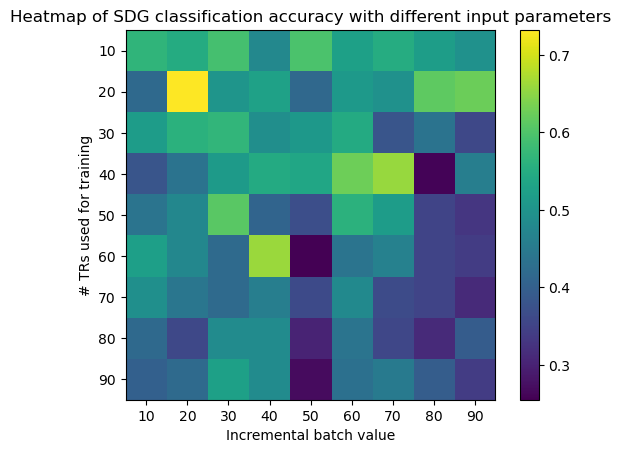

In [143]:
# We can visualize this parameter search by making a heat map
f, ax = plt.subplots()
im=ax.imshow(results, interpolation = 'none')
ax.set_xlabel("Incremental batch value")
ax.set_xticks(np.arange(results.shape[0]))
ax.set_xticklabels(batch_values)
ax.set_ylabel("# TRs used for training")
ax.set_yticks(np.arange(results.shape[1]))
ax.set_yticklabels(train_values)
ax.set_title("Heatmap of SDG classification accuracy with different input parameters")
f.colorbar(im, ax=ax)

**Exercise 8:**<a id="ex8"></a> Take a look at the `realtime`, `train`, and `train_incremental` functions again. What other parameters can you explore to try to maximize classification accuracy? Search over one or more parameters, then visualize the results of different combinations. 

In [67]:
len(alphas)

10

In [153]:
batch_values = range(10, 100, 10)
alpha_values = [1e-3, 1e-2, 1e-1, 1, 10, 100]
results2 = np.zeros((len(batch_values), len(alpha_values)))

for batch_counter in range(len(batch_values)):
    for alpha_counter in range(len(alpha_values)):
        
        # Pull out the values
        batch_size = batch_values[batch_counter]
        a = alpha_values[alpha_counter]
        
        
        
        def train_incremental2(training_data, training_labels, parameters=None):

            all_classes = np.array([1, 2])  # Need to say all the labels, in case you want to test out of sample

            # Get the clf
            if not parameters:
                # Create the linear if it hasn't already been passed in by parameters
                clf = linear_model.SGDClassifier(alpha = a)
            else:
                clf = parameters  # Pull out the classifier

            # Fit the training data (either initializing the clf or updating it)    
            clf.partial_fit(training_data, training_labels, classes=all_classes)

            return clf
        
        np.random.seed(0)
        print('batch size = %d, alpha = %d' % (batch_size, a))
        result2 = realtime(data_dir=data_dir,
                          train_count=train_count,
                          clf_obj=train_incremental2,
                          incremental_batch=batch_size,
                          display_figure=0
                         )

        # Store the results
        results2[batch_counter, alpha_counter] =  result2
            

batch size = 10, alpha = 0
batch size = 10, alpha = 0
batch size = 10, alpha = 0
batch size = 10, alpha = 1
batch size = 10, alpha = 10
batch size = 10, alpha = 100
batch size = 20, alpha = 0
batch size = 20, alpha = 0
batch size = 20, alpha = 0
batch size = 20, alpha = 1
batch size = 20, alpha = 10
batch size = 20, alpha = 100
batch size = 30, alpha = 0
batch size = 30, alpha = 0
batch size = 30, alpha = 0
batch size = 30, alpha = 1
batch size = 30, alpha = 10
batch size = 30, alpha = 100
batch size = 40, alpha = 0
batch size = 40, alpha = 0
batch size = 40, alpha = 0
batch size = 40, alpha = 1
batch size = 40, alpha = 10
batch size = 40, alpha = 100
batch size = 50, alpha = 0
batch size = 50, alpha = 0
batch size = 50, alpha = 0
batch size = 50, alpha = 1
batch size = 50, alpha = 10
batch size = 50, alpha = 100
batch size = 60, alpha = 0
batch size = 60, alpha = 0
batch size = 60, alpha = 0
batch size = 60, alpha = 1
batch size = 60, alpha = 10
batch size = 60, alpha = 100
batch size

In [151]:
results

array([[0.56613757, 0.54748603, 0.59171598, 0.47798742, 0.59731544,
        0.52517986, 0.5503876 , 0.5210084 , 0.49541284],
       [0.41798942, 0.73184358, 0.50295858, 0.52830189, 0.41610738,
        0.51079137, 0.49612403, 0.61344538, 0.62385321],
       [0.51851852, 0.55865922, 0.56804734, 0.49056604, 0.51006711,
        0.54676259, 0.37984496, 0.43697479, 0.35779817],
       [0.38095238, 0.43575419, 0.5147929 , 0.54716981, 0.53691275,
        0.62589928, 0.65891473, 0.2605042 , 0.4587156 ],
       [0.43915344, 0.47486034, 0.60946746, 0.40880503, 0.36912752,
        0.56115108, 0.51937984, 0.35294118, 0.33027523],
       [0.52380952, 0.47486034, 0.42011834, 0.66037736, 0.25503356,
        0.43884892, 0.46511628, 0.35294118, 0.33944954],
       [0.49206349, 0.44134078, 0.42011834, 0.4591195 , 0.36241611,
        0.48201439, 0.36434109, 0.35294118, 0.31192661],
       [0.41798942, 0.3575419 , 0.4852071 , 0.48427673, 0.30201342,
        0.43884892, 0.35658915, 0.31092437, 0.39449541],


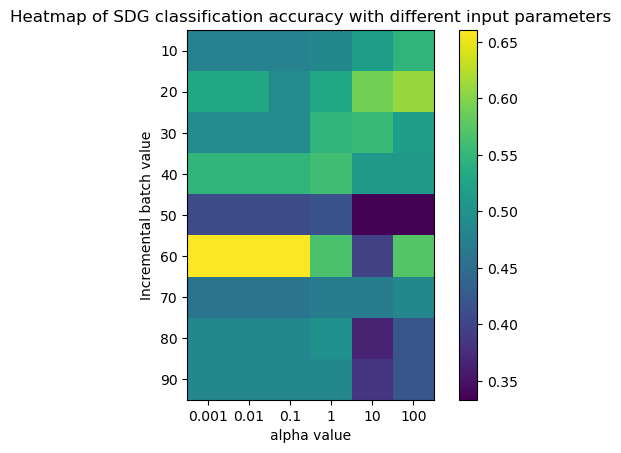

In [160]:
# We can visualize this parameter search by making a heat map
f, ax = plt.subplots()
im=ax.imshow(results2, interpolation = 'none')
ax.set_ylabel("Incremental batch value")
ax.set_yticks(np.arange(results2.shape[0]))
ax.set_yticklabels(batch_values)
ax.set_xlabel("alpha value")
ax.set_xticks(np.arange(results2.shape[1]))
ax.set_xticklabels(alpha_values)
ax.set_title("Heatmap of SDG classification accuracy with different input parameters")
f.colorbar(im, ax=ax)

**Novel contribution:**<a id="novel"></a> Be creative and make one new discovery by adding an analysis, visualization, or optimization.  

In [168]:
# Your last novel contribution of the semester goes here! 

penalty_values = ['l1', 'l2', 'elasticnet', None]
train_values = range(10, 100, 10)
results3 = np.zeros((len(penalty_values), len(train_values)))

for penalty_counter in range(len(penalty_values)):
    for train_counter in range(len(train_values)):
        
        # Pull out the values
        penalty_size = penalty_values[penalty_counter]
        train_size = train_values[train_counter]
        
        
        
        def train_incremental3(training_data, training_labels, parameters=None):

            all_classes = np.array([1, 2])  # Need to say all the labels, in case you want to test out of sample

            # Get the clf
            if not parameters:
                # Create the linear if it hasn't already been passed in by parameters
                clf = linear_model.SGDClassifier(alpha = 0.1, penalty = penalty_size)
            else:
                clf = parameters  # Pull out the classifier

            # Fit the training data (either initializing the clf or updating it)    
            clf.partial_fit(training_data, training_labels, classes=all_classes)

            return clf
        
        np.random.seed(0)
        print(f'penalty = {penalty_size}, train size = %d' % (train_size))
        result3 = realtime(data_dir=data_dir,
                          train_count=train_size,
                          clf_obj=train_incremental3,
                          incremental_batch=60,
                          display_figure=0
                         )

        # Store the results
        results3[penalty_counter, train_counter] =  result3
            

penalty = l1, train size = 10
penalty = l1, train size = 20
penalty = l1, train size = 30
penalty = l1, train size = 40
penalty = l1, train size = 50
penalty = l1, train size = 60
penalty = l1, train size = 70
penalty = l1, train size = 80
penalty = l1, train size = 90
penalty = l2, train size = 10
penalty = l2, train size = 20
penalty = l2, train size = 30
penalty = l2, train size = 40
penalty = l2, train size = 50
penalty = l2, train size = 60
penalty = l2, train size = 70
penalty = l2, train size = 80
penalty = l2, train size = 90
penalty = elasticnet, train size = 10
penalty = elasticnet, train size = 20
penalty = elasticnet, train size = 30
penalty = elasticnet, train size = 40
penalty = elasticnet, train size = 50
penalty = elasticnet, train size = 60
penalty = elasticnet, train size = 70
penalty = elasticnet, train size = 80
penalty = elasticnet, train size = 90
penalty = None, train size = 10
penalty = None, train size = 20
penalty = None, train size = 30
penalty = None, train 

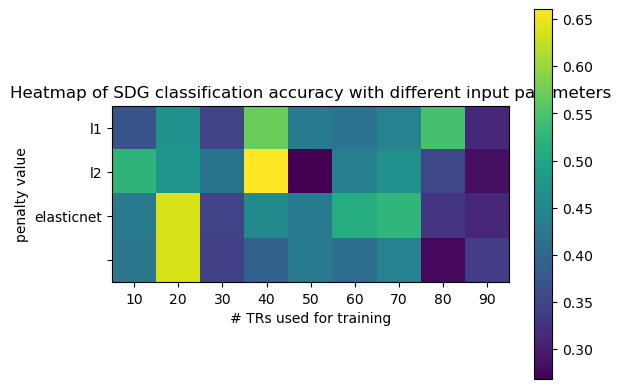

In [169]:
# We can visualize this parameter search by making a heat map
f, ax = plt.subplots()
im=ax.imshow(results3, interpolation = 'none')
ax.set_ylabel("penalty value")
ax.set_yticks(np.arange(results3.shape[0]))
ax.set_yticklabels(penalty_values)
ax.set_xlabel("# TRs used for training")
ax.set_xticks(np.arange(results3.shape[1]))
ax.set_xticklabels(train_values)
ax.set_title("Heatmap of SDG classification accuracy with different input parameters")
f.colorbar(im, ax=ax)

This additional visualization shows that the elasticnet and none penalty values tend to be a bit higher for 20 TR training in a batch size of 60, however l2 penalty and 40 TR is ideal for this batch size...

### Contributions<a id="contributions"></a>

G. Wallace for providing initial code.  
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 04/2018.  
G. Wallace enabled execution in non cluster environments.      
T. Yates made edits for cmhn_s21  
E. Busch made edits for cmhn_s22, cmhn_s23